In [79]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# signals
import mne
from scipy.signal import welch, get_window
from scipy.signal.windows import hamming

In [80]:
base_path_data = '/Users/tereza/nishant/atlas/epi_iEEG_atlas/Data'
hup_atlas = sio.loadmat(os.path.join(base_path_data, 'HUP_atlas.mat'))
mni_atlas = sio.loadmat(os.path.join(base_path_data, 'MNI_atlas.mat'))

In [81]:
hup_df = pd.DataFrame(hup_atlas['mni_coords'], columns=['x', 'y', 'z'])
mni_df = pd.DataFrame(mni_atlas['ChannelPosition'], columns=['x', 'y', 'z'])

hup_ts = pd.DataFrame(hup_atlas['wake_clip']) # (12000, 3431) @ x-axis is time steps, y-axis is electrodes
mni_ts = pd.DataFrame(mni_atlas['Data_W']) # (13600, 1765)  @ x-axis is time steps, y-axis is electrodes

hup_patients = pd.DataFrame(hup_atlas['patient_no'])
mni_patients = pd.DataFrame(mni_atlas['Patient'])

hup_patient_ids = np.unique(hup_atlas['patient_no'])
mni_patient_ids = np.unique(mni_atlas['Patient']) 

mni_samp_freq = int(mni_atlas['SamplingFrequency'].flatten()[~np.isnan(mni_atlas['SamplingFrequency'].flatten())][0])
hup_samp_freq = int(hup_atlas['SamplingFrequency'].flatten()[~np.isnan(hup_atlas['SamplingFrequency'].flatten())][0])

hup_patient_total_el_counts = len(hup_atlas['patient_no'])
mni_patient_total_el_counts = len(mni_atlas['Patient'])

hup_patient_numbers = hup_atlas['patient_no'].flatten()
hup_el_to_pat_map_dict = {}
for idx, patient_num in enumerate(hup_patient_numbers):
    hup_el_to_pat_map_dict[idx] = patient_num
hup_idx_map_arr = np.array([patient_num for patient_num in hup_patient_numbers]) # arr equivalent

mni_patient_numbers = mni_atlas['Patient'].flatten()
mni_el_to_pat_map_dict = {}
for idx, patient_num in enumerate(mni_patient_numbers):
    mni_el_to_pat_map_dict[idx] = patient_num
mni_idx_map_arr = np.array([patient_num for patient_num in mni_patient_numbers])

In [87]:
def get_norm_psd(iEEGnormal, data_timeS, sampling_frequency=200):
    """
    Function to compute normalized power spectral densities for different EEG frequency bands.
    
    Args:
    iEEGnormal (DataFrame): A DataFrame to append results to.
    data_timeS (array): Time domain EEG data for a single electrode (1D array)
    sampling_frequency (int): Sampling frequency of the EEG data.
    
    Returns:
    DataFrame: Updated DataFrame with new EEG features.
    """
    
    Fs = sampling_frequency
    window = Fs * 2
    NFFT = window
    
    # Compute PSD
    f, data_psd = welch(data_timeS, fs=Fs, window=hamming(window), 
                       nfft=NFFT, scaling='density', noverlap=window//2)
    
    # filter out noise frequency 57.5Hz to 62.5Hz
    noise_mask = (f >= 57.5) & (f <= 62.5)
    f = f[~noise_mask]
    # Handle 1D data_psd
    data_psd = data_psd[~noise_mask]
    
    def bandpower(psd, freqs, freq_range):
        """Calculate power in the given frequency range."""
        idx = np.logical_and(freqs >= freq_range[0], freqs <= freq_range[1])
        return np.trapz(psd[idx], freqs[idx])
    
    # Define frequency bands
    bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 13), 
             'beta': (13, 30), 'gamma': (30, 80), 'broad': (1, 80)}
    
    # Calculate band powers (using 1D data_psd)
    band_powers = {band: bandpower(data_psd, f, freq_range) 
                  for band, freq_range in bands.items()}
    
    # Compute log transform
    log_band_powers = {f'{band}log': np.log10(power + 1) 
                      for band, power in band_powers.items()}
    
    # Calculate total power
    total_band_power = np.sum([value for value in log_band_powers.values()])
    
    # Calculate relative powers
    relative_band_powers = {f'{band}Rel': log_band_powers[f'{band}log'] / total_band_power 
                          for band in bands}
    
    # Create DataFrame row
    data_to_append = pd.DataFrame([relative_band_powers])
    data_to_append['broadlog'] = log_band_powers['broadlog']
    
    # Append to existing DataFrame
    iEEGnormal = pd.concat([iEEGnormal, data_to_append], ignore_index=True)
    
    return iEEGnormal

For HUP data:
Processed from patient 1 to patient 60
Last processed electrode is 3430
Each electrode's time series has shape (12000,)


For MNI data:
Processed from patient 1 to patient 110
Last processed electrode is 1764
Each electrode's time series has shape (13600,)

In [90]:
hup_iEEGnormal = pd.DataFrame()
mni_iEEGnormal = pd.DataFrame()

# for each patient, for each electrode, compute PSD
for patient in hup_patient_ids:
    # print(f"Processing HUP patient {patient}")
    patient_el_ids = np.where(hup_idx_map_arr == patient)[0]
    # print(f"Found {len(patient_el_ids)} electrodes")
    
    for idx in patient_el_ids:
        # print(f"Processing electrode {idx}")
        hup_electrode_data = hup_ts.iloc[:, idx].values
        # print(f"Electrode data shape: {hup_electrode_data.shape}")
        hup_iEEGnormal = get_norm_psd(hup_iEEGnormal, hup_electrode_data)
        # print(f"Processed electrode {idx}, DataFrame now has {len(hup_iEEGnormal)} rows")

# print("\nFinished HUP processing, starting MNI\n")

# For each electrode, we get one scalar value per frequency band for the entire duration of the signal
for patient in mni_patient_ids:
    # print(f"Processing MNI patient {patient}")
    patient_el_ids = np.where(mni_idx_map_arr == patient)[0]
    # print(f"Found {len(patient_el_ids)} electrodes")
    
    for idx in patient_el_ids:
        # print(f"Processing electrode {idx}")
        mni_electrode_data = mni_ts.iloc[:, idx].values
        # print(f"Electrode data shape: {mni_electrode_data.shape}")
        mni_iEEGnormal = get_norm_psd(mni_iEEGnormal, mni_electrode_data)
        # print(f"Processed electrode {idx}, DataFrame now has {len(mni_iEEGnormal)} rows")

In [91]:
# Check dimensions of both DataFrames
print("HUP DataFrame shape:", hup_iEEGnormal.shape)
print("MNI DataFrame shape:", mni_iEEGnormal.shape)

# Check the number of unique patients that were processed
print("\nNumber of patients processed:")
print("HUP patients:", len(hup_patient_ids))
print("MNI patients:", len(mni_patient_ids))

# Verify total electrode counts
print("\nTotal electrode counts:")
print("HUP electrodes in original data:", hup_ts.shape[1])  # From (12000, 3431)
print("HUP electrodes processed:", len(hup_iEEGnormal))
print("MNI electrodes in original data:", mni_ts.shape[1])  # From (13600, 1765)
print("MNI electrodes processed:", len(mni_iEEGnormal))

# Check what columns we got (spectral features)
print("\nSpectral features computed:")
print(hup_iEEGnormal.columns.tolist())

# Let's look at the first few rows of data to verify values are reasonable
print("\nFirst few rows of HUP data:")
print(hup_iEEGnormal.head())

HUP DataFrame shape: (3431, 7)
MNI DataFrame shape: (1765, 7)

Number of patients processed:
HUP patients: 60
MNI patients: 106

Total electrode counts:
HUP electrodes in original data: 3431
HUP electrodes processed: 3431
MNI electrodes in original data: 1765
MNI electrodes processed: 1765

Spectral features computed:
['deltaRel', 'thetaRel', 'alphaRel', 'betaRel', 'gammaRel', 'broadRel', 'broadlog']

First few rows of HUP data:
   deltaRel  thetaRel  alphaRel   betaRel  gammaRel  broadRel  broadlog
0  0.177924  0.147311  0.135588  0.173211  0.139114  0.226852  2.281969
1  0.210691  0.231001  0.098005  0.129331  0.048090  0.282882  1.720748
2  0.248122  0.184206  0.116251  0.126453  0.059346  0.265622  2.333526
3  0.214907  0.162279  0.114287  0.135578  0.073299  0.299651  1.216269
4  0.187794  0.182233  0.136686  0.152295  0.069230  0.271761  1.517257


Stats


Detailed Statistical Results:

Significant differences (after correction):
------------------------------------------

deltaRel:
  HUP: 0.195 ± 0.032
  MNI: 0.178 ± 0.025
  Effect Size: 0.322
  Corrected p-value: 0.0000

thetaRel:
  HUP: 0.173 ± 0.018
  MNI: 0.169 ± 0.021
  Effect Size: 0.169
  Corrected p-value: 0.0000

alphaRel:
  HUP: 0.153 ± 0.023
  MNI: 0.157 ± 0.022
  Effect Size: -0.085
  Corrected p-value: 0.0000

betaRel:
  HUP: 0.149 ± 0.024
  MNI: 0.164 ± 0.023
  Effect Size: -0.350
  Corrected p-value: 0.0000

broadRel:
  HUP: 0.231 ± 0.028
  MNI: 0.232 ± 0.020
  Effect Size: -0.117
  Corrected p-value: 0.0000

broadlog:
  HUP: 2.930 ± 0.636
  MNI: 2.618 ± 0.588
  Effect Size: 0.312
  Corrected p-value: 0.0000

Non-significant differences:
--------------------------

gammaRel:
  HUP: 0.099 ± 0.029
  MNI: 0.100 ± 0.030
  Effect Size: -0.022
  Original p-value: 0.2029


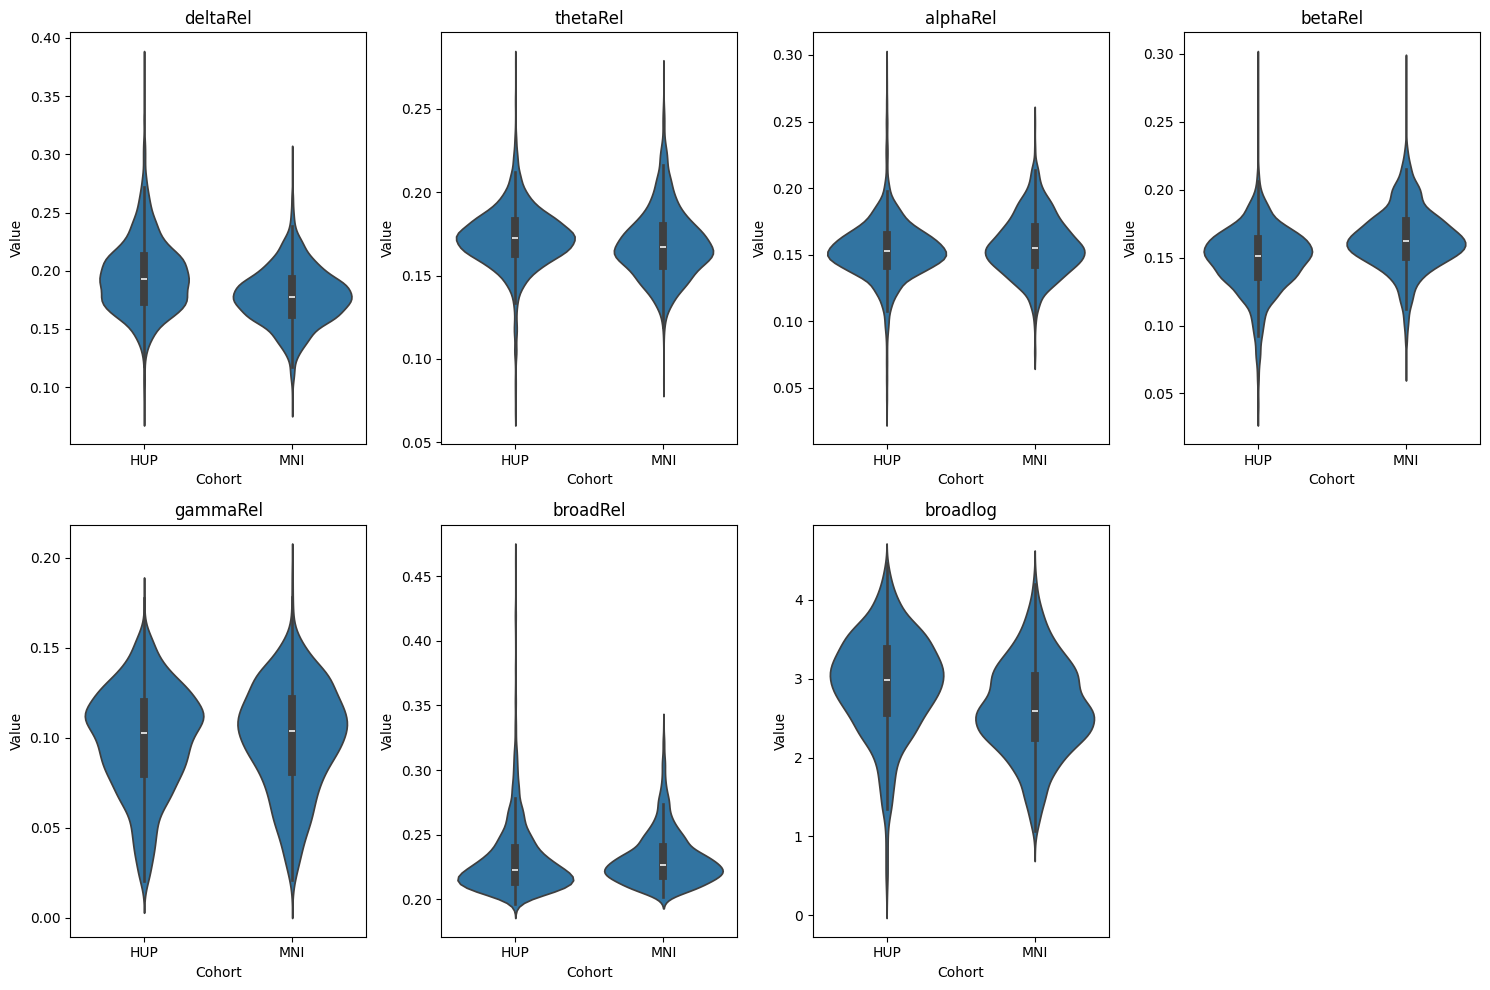

In [93]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

def compare_cohorts(hup_df, mni_df, features=None):
    """
    Perform statistical comparison between HUP and MNI cohorts for spectral features.
    
    Args:
        hup_df (pd.DataFrame): HUP cohort data
        mni_df (pd.DataFrame): MNI cohort data
        features (list): List of features to compare. If None, uses all columns
    
    Returns:
        dict: Contains test results, effect sizes, and summary statistics
    """
    if features is None:
        features = hup_df.columns
    
    results = {
        'statistics': [],
        'pvalues': [],
        'effect_sizes': [],
        'hup_medians': [],
        'mni_medians': [],
        'features': features
    }
    
    # Perform statistical tests for each feature
    for feature in features:
        # Mann-Whitney U test (non-parametric comparison)
        statistic, pvalue = stats.mannwhitneyu(
            hup_df[feature], 
            mni_df[feature],
            alternative='two-sided'
        )
        
        # Calculate effect size (Cliff's Delta)
        d = cliff_delta(hup_df[feature].values, mni_df[feature].values)
        
        results['statistics'].append(statistic)
        results['pvalues'].append(pvalue)
        results['effect_sizes'].append(d)
        results['hup_medians'].append(hup_df[feature].median())
        results['mni_medians'].append(mni_df[feature].median())
    
    # Correct for multiple comparisons using FDR
    results['pvalues_corrected'] = multipletests(
        results['pvalues'], 
        method='fdr_bh'
    )[1]
    
    return results

def cliff_delta(x, y):
    """Calculate Cliff's Delta effect size."""
    nx, ny = len(x), len(y)
    dominance = 0
    
    for i in x:
        for j in y:
            if i > j:
                dominance += 1
            elif i < j:
                dominance -= 1
                
    return dominance / (nx * ny)

def plot_comparisons(hup_df, mni_df, features=None):
    """
    Create visualization comparing distributions between cohorts.
    
    Args:
        hup_df (pd.DataFrame): HUP cohort data
        mni_df (pd.DataFrame): MNI cohort data
        features (list): Features to plot. If None, uses all columns
    """
    if features is None:
        features = hup_df.columns
    
    # Set up the plot
    n_features = len(features)
    fig, axes = plt.subplots(2, (n_features + 1) // 2, figsize=(15, 10))
    axes = axes.flatten()
    
    # Create violin plots for each feature
    for idx, feature in enumerate(features):
        # Prepare data for violin plot
        data = pd.DataFrame({
            'Value': pd.concat([hup_df[feature], mni_df[feature]]),
            'Cohort': ['HUP'] * len(hup_df) + ['MNI'] * len(mni_df)
        })
        
        # Create violin plot
        sns.violinplot(data=data, x='Cohort', y='Value', ax=axes[idx])
        axes[idx].set_title(feature)
        axes[idx].set_ylabel('Value')
    
    # Remove any empty subplots
    for idx in range(n_features, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    return fig

# Example usage
def analyze_cohorts(hup_df, mni_df):
    """
    Perform complete analysis of HUP vs MNI cohorts.
    
    Args:
        hup_df (pd.DataFrame): HUP cohort spectral features
        mni_df (pd.DataFrame): MNI cohort spectral features
    """
    # Perform statistical comparison
    results = compare_cohorts(hup_df, mni_df)
    
    # Create summary table
    summary = pd.DataFrame({
        'Feature': results['features'],
        'HUP_Median': results['hup_medians'],
        'MNI_Median': results['mni_medians'],
        'Effect_Size': results['effect_sizes'],
        'P_Value': results['pvalues'],
        'P_Value_Corrected': results['pvalues_corrected']
    })
    
    # Print summary
    print("\nStatistical Comparison Summary:")
    print("--------------------------------")
    print(summary.round(4))
    
    # Create visualization
    fig = plot_comparisons(hup_df, mni_df)
    
    return summary, fig

# Run the analysis
summary, fig = analyze_cohorts(hup_iEEGnormal, mni_iEEGnormal)

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

def compare_cohorts(hup_df, mni_df, features=None, alpha=0.05):
    """
    Perform statistical comparison between HUP and MNI cohorts for spectral features.
    
    Args:
        hup_df (pd.DataFrame): HUP cohort data
        mni_df (pd.DataFrame): MNI cohort data
        features (list): List of features to compare. If None, uses all columns
        alpha (float): Significance level
    
    Returns:
        dict: Contains test results, effect sizes, and summary statistics
    """
    if features is None:
        features = hup_df.columns
    
    results = {
        'statistics': [],
        'pvalues': [],
        'effect_sizes': [],
        'hup_medians': [],
        'mni_medians': [],
        'hup_means': [],
        'mni_means': [],
        'hup_stds': [],
        'mni_stds': [],
        'features': features
    }
    
    # Perform statistical tests for each feature
    for feature in features:
        # Mann-Whitney U test
        statistic, pvalue = stats.mannwhitneyu(
            hup_df[feature], 
            mni_df[feature],
            alternative='two-sided'
        )
        
        # Calculate effect size (Cliff's Delta)
        d = cliff_delta(hup_df[feature].values, mni_df[feature].values)
        
        # Store results
        results['statistics'].append(statistic)
        results['pvalues'].append(pvalue)
        results['effect_sizes'].append(d)
        results['hup_medians'].append(hup_df[feature].median())
        results['mni_medians'].append(mni_df[feature].median())
        results['hup_means'].append(hup_df[feature].mean())
        results['mni_means'].append(mni_df[feature].mean())
        results['hup_stds'].append(hup_df[feature].std())
        results['mni_stds'].append(mni_df[feature].std())
    
    # Correct for multiple comparisons
    results['pvalues_corrected'] = multipletests(
        results['pvalues'], 
        method='fdr_bh'
    )[1]
    
    return results

def cliff_delta(x, y):
    """Calculate Cliff's Delta effect size."""
    nx, ny = len(x), len(y)
    dominance = 0
    
    for i in x:
        for j in y:
            if i > j:
                dominance += 1
            elif i < j:
                dominance -= 1
                
    return dominance / (nx * ny)

def print_statistical_results(results, alpha=0.05):
    """Print detailed statistical results with significance indicators."""
    print("\nDetailed Statistical Results:")
    print("============================")
    
    significant_features = []
    marginally_significant_features = []
    nonsignificant_features = []
    
    for i, feature in enumerate(results['features']):
        result_dict = {
            'Feature': feature,
            'HUP Mean ± SD': f"{results['hup_means'][i]:.3f} ± {results['hup_stds'][i]:.3f}",
            'MNI Mean ± SD': f"{results['mni_means'][i]:.3f} ± {results['mni_stds'][i]:.3f}",
            'Effect Size': f"{results['effect_sizes'][i]:.3f}",
            'P-value': results['pvalues'][i],
            'Corrected P-value': results['pvalues_corrected'][i]
        }
        
        if results['pvalues_corrected'][i] < alpha:
            significant_features.append(result_dict)
        elif results['pvalues'][i] < alpha:
            marginally_significant_features.append(result_dict)
        else:
            nonsignificant_features.append(result_dict)
    
    # Print significant results
    if significant_features:
        print("\nSignificant differences (after correction):")
        print("------------------------------------------")
        for result in significant_features:
            print(f"\n{result['Feature']}:")
            print(f"  HUP: {result['HUP Mean ± SD']}")
            print(f"  MNI: {result['MNI Mean ± SD']}")
            print(f"  Effect Size: {result['Effect Size']}")
            print(f"  Corrected p-value: {result['Corrected P-value']:.4f}")
    
    # Print marginally significant results
    if marginally_significant_features:
        print("\nMarginally significant differences (before correction):")
        print("---------------------------------------------------")
        for result in marginally_significant_features:
            print(f"\n{result['Feature']}:")
            print(f"  HUP: {result['HUP Mean ± SD']}")
            print(f"  MNI: {result['MNI Mean ± SD']}")
            print(f"  Effect Size: {result['Effect Size']}")
            print(f"  Original p-value: {result['P-value']:.4f}")
    
    # Print non-significant results
    if nonsignificant_features:
        print("\nNon-significant differences:")
        print("--------------------------")
        for result in nonsignificant_features:
            print(f"\n{result['Feature']}:")
            print(f"  HUP: {result['HUP Mean ± SD']}")
            print(f"  MNI: {result['MNI Mean ± SD']}")
            print(f"  Effect Size: {result['Effect Size']}")
            print(f"  Original p-value: {result['P-value']:.4f}")

def analyze_cohorts(hup_df, mni_df, alpha=0.05):
    """
    Perform complete analysis of HUP vs MNI cohorts.
    
    Args:
        hup_df (pd.DataFrame): HUP cohort spectral features
        mni_df (pd.DataFrame): MNI cohort spectral features
        alpha (float): Significance level
    """
    # Perform statistical comparison
    results = compare_cohorts(hup_df, mni_df, alpha=alpha)
    
    # Print detailed statistical results
    print_statistical_results(results, alpha)
    
    # Create visualization
    fig = plot_comparisons(hup_df, mni_df)
    
    return results, fig

# Example usage:
results, fig = analyze_cohorts(hup_iEEGnormal, mni_iEEGnormal)
plt.show()